# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Extracting mnist: 100%|██████████████████████████████████████████████████████████| 60.0K/60.0K [03:42<00:00, 269File/s]


Extracting celeba...


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

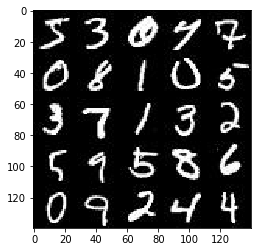

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

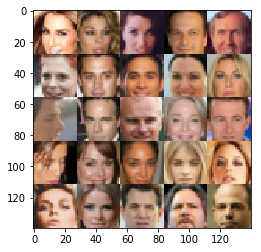

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs = tf.placeholder(tf.float32, shape=[None, image_width, image_height, image_channels], name="inputs")
    z_dim = tf.placeholder(tf.float32, (None, z_dim), name="input_fake")
    learning_rate = tf.placeholder(tf.float32, name="learning_rate") 

    return inputs, z_dim, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        
        alpha = 0.2
        
        layer_1 = tf.layers.conv2d(images,64,5,strides=2,padding='same', 
                                   kernel_initializer=tf.random_normal_initializer(stddev=0.01))
        layer_1 = tf.maximum(alpha * layer_1, layer_1)
        
        layer_2 = tf.layers.conv2d(layer_1,128,5,strides=2,padding='same',
                                  kernel_initializer=tf.random_normal_initializer(stddev=0.01))
        bn_2 = tf.layers.batch_normalization(layer_2, training=True)
        layer_2 = tf.maximum(alpha * layer_2, layer_2)
        
        layer_3 = tf.layers.conv2d(layer_2,256,5,strides=1,padding='same',
                                  kernel_initializer=tf.random_normal_initializer(stddev=0.1))
        bn_3 = tf.layers.batch_normalization(layer_3, training=True)
        layer_3 = tf.maximum(alpha * layer_3, layer_3)
        
        layer_4 = tf.layers.conv2d(layer_3,512,5,strides=1,padding='same',
                                  kernel_initializer=tf.random_normal_initializer(stddev=0.1))
        bn_4 = tf.layers.batch_normalization(layer_4, training=True)
        layer_4 = tf.maximum(alpha * layer_4, layer_4)
        
        dimensions = layer_4.get_shape().as_list()
        
        flat = tf.reshape(layer_4, (-1,dimensions[1]*dimensions[2]*dimensions[3]))
        logits= tf.layers.dense(flat, 1)
        output = tf.sigmoid(logits)
        return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse = not is_train):
        
        stack = tf.layers.dense(z, 7*7*512)
        alpha = 0.2
        stack_reshaped = tf.reshape(stack,(-1,7,7,512))
        stack_normalized = tf.layers.batch_normalization(stack_reshaped, training=is_train)
        stack_normalized = tf.maximum(alpha * stack_normalized, stack_normalized)
        
        deconv_1 = tf.layers.conv2d_transpose(stack_normalized, 256, 5, strides=2, padding='same',
                                              kernel_initializer=tf.random_normal_initializer(stddev=0.01))
        deconv_1 = tf.layers.batch_normalization(deconv_1, training=is_train)
        deconv_1 = tf.maximum(alpha * deconv_1, deconv_1)
        
        deconv_2 = tf.layers.conv2d_transpose(deconv_1,128,5,strides=2,padding='same',
                                             kernel_initializer=tf.random_normal_initializer(stddev=0.01))
        deconv_2 = tf.layers.batch_normalization(deconv_2, training=is_train)
        deconv_2 = tf.maximum(alpha * deconv_2, deconv_2)
        
        deconv_3 = tf.layers.conv2d_transpose(deconv_2,64,5,strides=1,padding='same',
                                             kernel_initializer=tf.random_normal_initializer(stddev=0.01))
        deconv_3 = tf.layers.batch_normalization(deconv_3, training=is_train)
        deconv_3 = tf.maximum(alpha * deconv_3, deconv_3)
        
        logits = tf.layers.conv2d_transpose(deconv_3, out_channel_dim, 5, strides=1, padding='same', 
                                           kernel_initializer=tf.random_normal_initializer(stddev=0.01))
        
        output = tf.tanh(logits)
        
        return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse = True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real,labels=tf.ones_like(d_model_real) * 0.9))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,labels=tf.ones_like(d_model_fake)))
    
    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
        
                
    _, image_width, image_height, image_channels = data_shape
    input_real, input_z, learning_rate_ph = model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate_ph, beta1)
    
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                
                batch_images = batch_images*2

                batch_z = np.random.uniform(-1,1, size=(batch_size, z_dim))

                sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, 
                                               learning_rate_ph: learning_rate})

                sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z,
                                               learning_rate_ph: learning_rate})

                if steps % 10 == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z, input_real: batch_images})

                    print("Epoch: {}/{} ...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss is: {:.4f}...".format(train_loss_d),
                          "Generator Loss is: {:.4f}".format(train_loss_g))

                if steps % 100 == 0:
                    show_generator_output(sess, 25, input_z, image_channels, data_image_mode)
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch: 1/2 ... Discriminator Loss is: 1.3060... Generator Loss is: 0.6454
Epoch: 1/2 ... Discriminator Loss is: 1.1267... Generator Loss is: 1.0420
Epoch: 1/2 ... Discriminator Loss is: 0.9662... Generator Loss is: 1.0436
Epoch: 1/2 ... Discriminator Loss is: 0.7919... Generator Loss is: 1.2482
Epoch: 1/2 ... Discriminator Loss is: 1.2234... Generator Loss is: 1.3253
Epoch: 1/2 ... Discriminator Loss is: 1.3209... Generator Loss is: 0.8045
Epoch: 1/2 ... Discriminator Loss is: 1.7320... Generator Loss is: 0.3653
Epoch: 1/2 ... Discriminator Loss is: 1.0485... Generator Loss is: 1.0024
Epoch: 1/2 ... Discriminator Loss is: 1.3051... Generator Loss is: 0.8245
Epoch: 1/2 ... Discriminator Loss is: 1.1904... Generator Loss is: 0.9088


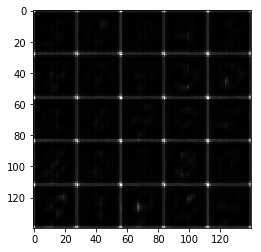

Epoch: 1/2 ... Discriminator Loss is: 1.3199... Generator Loss is: 0.9872
Epoch: 1/2 ... Discriminator Loss is: 1.1922... Generator Loss is: 1.0121
Epoch: 1/2 ... Discriminator Loss is: 1.3251... Generator Loss is: 0.6606
Epoch: 1/2 ... Discriminator Loss is: 1.2852... Generator Loss is: 0.7446
Epoch: 1/2 ... Discriminator Loss is: 1.1189... Generator Loss is: 0.8444
Epoch: 1/2 ... Discriminator Loss is: 1.2518... Generator Loss is: 0.9675
Epoch: 1/2 ... Discriminator Loss is: 1.7395... Generator Loss is: 1.6726
Epoch: 1/2 ... Discriminator Loss is: 1.2619... Generator Loss is: 0.8428
Epoch: 1/2 ... Discriminator Loss is: 1.2197... Generator Loss is: 0.9502
Epoch: 1/2 ... Discriminator Loss is: 1.1323... Generator Loss is: 1.0060


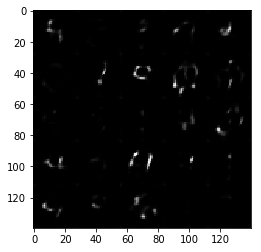

Epoch: 1/2 ... Discriminator Loss is: 1.1507... Generator Loss is: 1.0763
Epoch: 1/2 ... Discriminator Loss is: 1.2569... Generator Loss is: 0.8886
Epoch: 1/2 ... Discriminator Loss is: 1.3634... Generator Loss is: 0.7331
Epoch: 1/2 ... Discriminator Loss is: 1.2352... Generator Loss is: 0.7806
Epoch: 1/2 ... Discriminator Loss is: 1.1079... Generator Loss is: 1.1328
Epoch: 1/2 ... Discriminator Loss is: 0.9522... Generator Loss is: 1.3076
Epoch: 1/2 ... Discriminator Loss is: 1.0058... Generator Loss is: 1.3511
Epoch: 1/2 ... Discriminator Loss is: 0.9970... Generator Loss is: 0.9810
Epoch: 1/2 ... Discriminator Loss is: 1.2502... Generator Loss is: 1.1187
Epoch: 1/2 ... Discriminator Loss is: 1.0127... Generator Loss is: 1.1035


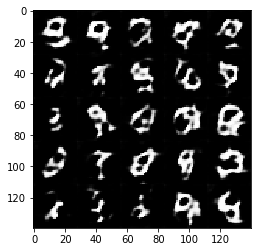

Epoch: 1/2 ... Discriminator Loss is: 1.0834... Generator Loss is: 1.1625
Epoch: 1/2 ... Discriminator Loss is: 1.3349... Generator Loss is: 0.9304
Epoch: 1/2 ... Discriminator Loss is: 1.0798... Generator Loss is: 1.2418
Epoch: 1/2 ... Discriminator Loss is: 1.1147... Generator Loss is: 1.1369
Epoch: 1/2 ... Discriminator Loss is: 1.2639... Generator Loss is: 0.9187
Epoch: 1/2 ... Discriminator Loss is: 1.0980... Generator Loss is: 1.3771
Epoch: 1/2 ... Discriminator Loss is: 1.1161... Generator Loss is: 1.2891
Epoch: 1/2 ... Discriminator Loss is: 1.0464... Generator Loss is: 1.0106
Epoch: 1/2 ... Discriminator Loss is: 1.0324... Generator Loss is: 0.9742
Epoch: 1/2 ... Discriminator Loss is: 1.1386... Generator Loss is: 0.8694


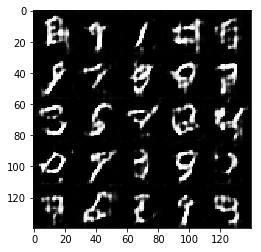

Epoch: 1/2 ... Discriminator Loss is: 1.1973... Generator Loss is: 1.0739
Epoch: 1/2 ... Discriminator Loss is: 1.2101... Generator Loss is: 0.9684
Epoch: 1/2 ... Discriminator Loss is: 1.2414... Generator Loss is: 0.9087
Epoch: 1/2 ... Discriminator Loss is: 1.1658... Generator Loss is: 1.1040
Epoch: 1/2 ... Discriminator Loss is: 1.2989... Generator Loss is: 0.9129
Epoch: 1/2 ... Discriminator Loss is: 1.2308... Generator Loss is: 0.8514
Epoch: 1/2 ... Discriminator Loss is: 1.2538... Generator Loss is: 0.7390
Epoch: 1/2 ... Discriminator Loss is: 1.1933... Generator Loss is: 1.0931
Epoch: 1/2 ... Discriminator Loss is: 1.1570... Generator Loss is: 0.9590
Epoch: 1/2 ... Discriminator Loss is: 1.2251... Generator Loss is: 0.9511


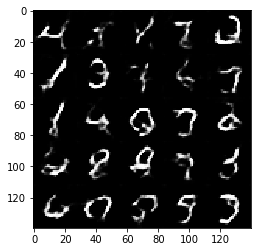

Epoch: 1/2 ... Discriminator Loss is: 1.2322... Generator Loss is: 0.7646
Epoch: 1/2 ... Discriminator Loss is: 1.2566... Generator Loss is: 0.8334
Epoch: 1/2 ... Discriminator Loss is: 1.2141... Generator Loss is: 0.8668
Epoch: 1/2 ... Discriminator Loss is: 1.2311... Generator Loss is: 1.0059
Epoch: 1/2 ... Discriminator Loss is: 1.4028... Generator Loss is: 0.5781
Epoch: 1/2 ... Discriminator Loss is: 1.1495... Generator Loss is: 1.0580
Epoch: 1/2 ... Discriminator Loss is: 1.2638... Generator Loss is: 0.9231
Epoch: 1/2 ... Discriminator Loss is: 1.1517... Generator Loss is: 0.9679
Epoch: 1/2 ... Discriminator Loss is: 1.2918... Generator Loss is: 0.8464
Epoch: 1/2 ... Discriminator Loss is: 1.2857... Generator Loss is: 1.0165


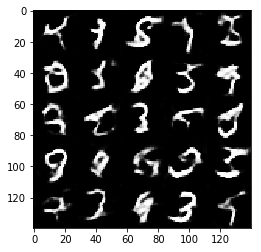

Epoch: 1/2 ... Discriminator Loss is: 1.2244... Generator Loss is: 1.1309
Epoch: 1/2 ... Discriminator Loss is: 1.2456... Generator Loss is: 1.0393
Epoch: 1/2 ... Discriminator Loss is: 1.2495... Generator Loss is: 0.7937
Epoch: 1/2 ... Discriminator Loss is: 1.2986... Generator Loss is: 0.8689
Epoch: 1/2 ... Discriminator Loss is: 1.1950... Generator Loss is: 1.0635
Epoch: 1/2 ... Discriminator Loss is: 1.1390... Generator Loss is: 1.0929
Epoch: 1/2 ... Discriminator Loss is: 1.2376... Generator Loss is: 1.0205
Epoch: 1/2 ... Discriminator Loss is: 1.2444... Generator Loss is: 0.9361
Epoch: 1/2 ... Discriminator Loss is: 1.1904... Generator Loss is: 0.9183
Epoch: 1/2 ... Discriminator Loss is: 1.2486... Generator Loss is: 0.8135


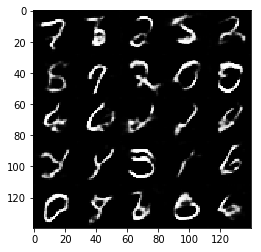

Epoch: 1/2 ... Discriminator Loss is: 1.2950... Generator Loss is: 1.3325
Epoch: 1/2 ... Discriminator Loss is: 1.2747... Generator Loss is: 0.9293
Epoch: 1/2 ... Discriminator Loss is: 1.1088... Generator Loss is: 1.2219
Epoch: 1/2 ... Discriminator Loss is: 1.2331... Generator Loss is: 1.0407
Epoch: 1/2 ... Discriminator Loss is: 1.1569... Generator Loss is: 0.8494
Epoch: 1/2 ... Discriminator Loss is: 1.0851... Generator Loss is: 1.2798
Epoch: 1/2 ... Discriminator Loss is: 1.2689... Generator Loss is: 1.2909
Epoch: 1/2 ... Discriminator Loss is: 1.0277... Generator Loss is: 1.1994
Epoch: 1/2 ... Discriminator Loss is: 1.2186... Generator Loss is: 0.8867
Epoch: 1/2 ... Discriminator Loss is: 1.2498... Generator Loss is: 1.0356


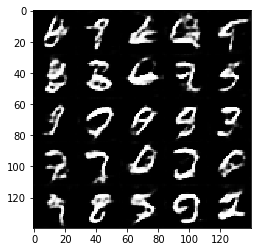

Epoch: 1/2 ... Discriminator Loss is: 1.2688... Generator Loss is: 0.8778
Epoch: 1/2 ... Discriminator Loss is: 1.1844... Generator Loss is: 0.9731
Epoch: 1/2 ... Discriminator Loss is: 1.2562... Generator Loss is: 0.9336
Epoch: 1/2 ... Discriminator Loss is: 1.2124... Generator Loss is: 1.0159
Epoch: 1/2 ... Discriminator Loss is: 1.1951... Generator Loss is: 0.9179
Epoch: 2/2 ... Discriminator Loss is: 1.2598... Generator Loss is: 1.1287
Epoch: 2/2 ... Discriminator Loss is: 1.2963... Generator Loss is: 0.8454
Epoch: 2/2 ... Discriminator Loss is: 1.3273... Generator Loss is: 0.9169
Epoch: 2/2 ... Discriminator Loss is: 1.2908... Generator Loss is: 1.0513
Epoch: 2/2 ... Discriminator Loss is: 1.1959... Generator Loss is: 0.9482


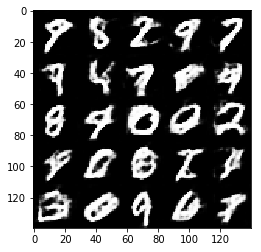

Epoch: 2/2 ... Discriminator Loss is: 1.1754... Generator Loss is: 1.0940
Epoch: 2/2 ... Discriminator Loss is: 1.1879... Generator Loss is: 0.8934
Epoch: 2/2 ... Discriminator Loss is: 1.4645... Generator Loss is: 0.8794
Epoch: 2/2 ... Discriminator Loss is: 1.2389... Generator Loss is: 0.8306
Epoch: 2/2 ... Discriminator Loss is: 1.2007... Generator Loss is: 1.0148
Epoch: 2/2 ... Discriminator Loss is: 1.2156... Generator Loss is: 1.1137
Epoch: 2/2 ... Discriminator Loss is: 1.1837... Generator Loss is: 0.9563
Epoch: 2/2 ... Discriminator Loss is: 1.3222... Generator Loss is: 0.7716
Epoch: 2/2 ... Discriminator Loss is: 1.4448... Generator Loss is: 0.5505
Epoch: 2/2 ... Discriminator Loss is: 1.2105... Generator Loss is: 0.8505


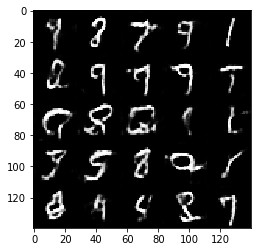

Epoch: 2/2 ... Discriminator Loss is: 1.1763... Generator Loss is: 0.9372
Epoch: 2/2 ... Discriminator Loss is: 1.3587... Generator Loss is: 0.7935
Epoch: 2/2 ... Discriminator Loss is: 1.1819... Generator Loss is: 1.0672
Epoch: 2/2 ... Discriminator Loss is: 1.1559... Generator Loss is: 0.9857
Epoch: 2/2 ... Discriminator Loss is: 1.1728... Generator Loss is: 1.1073
Epoch: 2/2 ... Discriminator Loss is: 1.2061... Generator Loss is: 0.8032
Epoch: 2/2 ... Discriminator Loss is: 1.1769... Generator Loss is: 1.0168
Epoch: 2/2 ... Discriminator Loss is: 1.2849... Generator Loss is: 0.7437
Epoch: 2/2 ... Discriminator Loss is: 1.2935... Generator Loss is: 0.9568
Epoch: 2/2 ... Discriminator Loss is: 1.2106... Generator Loss is: 0.9829


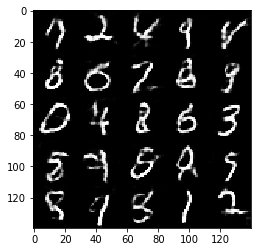

Epoch: 2/2 ... Discriminator Loss is: 1.2267... Generator Loss is: 0.9892
Epoch: 2/2 ... Discriminator Loss is: 1.2582... Generator Loss is: 0.9104
Epoch: 2/2 ... Discriminator Loss is: 1.1892... Generator Loss is: 1.1886
Epoch: 2/2 ... Discriminator Loss is: 1.3249... Generator Loss is: 0.7869
Epoch: 2/2 ... Discriminator Loss is: 1.2876... Generator Loss is: 0.8750
Epoch: 2/2 ... Discriminator Loss is: 1.2437... Generator Loss is: 0.9400
Epoch: 2/2 ... Discriminator Loss is: 1.2504... Generator Loss is: 1.1540
Epoch: 2/2 ... Discriminator Loss is: 1.0808... Generator Loss is: 0.9809
Epoch: 2/2 ... Discriminator Loss is: 1.1318... Generator Loss is: 1.1184
Epoch: 2/2 ... Discriminator Loss is: 1.2090... Generator Loss is: 0.8408


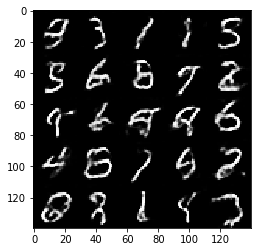

Epoch: 2/2 ... Discriminator Loss is: 1.1964... Generator Loss is: 0.9536
Epoch: 2/2 ... Discriminator Loss is: 1.2171... Generator Loss is: 0.9067
Epoch: 2/2 ... Discriminator Loss is: 1.2326... Generator Loss is: 1.0556
Epoch: 2/2 ... Discriminator Loss is: 1.2369... Generator Loss is: 0.8264
Epoch: 2/2 ... Discriminator Loss is: 1.1918... Generator Loss is: 0.9679
Epoch: 2/2 ... Discriminator Loss is: 1.2289... Generator Loss is: 0.8580
Epoch: 2/2 ... Discriminator Loss is: 1.3269... Generator Loss is: 0.9087
Epoch: 2/2 ... Discriminator Loss is: 1.1654... Generator Loss is: 1.1660
Epoch: 2/2 ... Discriminator Loss is: 1.2938... Generator Loss is: 0.8293
Epoch: 2/2 ... Discriminator Loss is: 1.1521... Generator Loss is: 1.0447


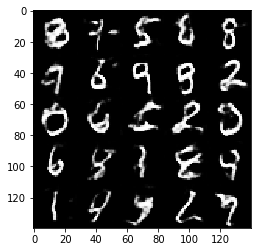

Epoch: 2/2 ... Discriminator Loss is: 1.2491... Generator Loss is: 0.9047
Epoch: 2/2 ... Discriminator Loss is: 1.2391... Generator Loss is: 0.8576
Epoch: 2/2 ... Discriminator Loss is: 1.2425... Generator Loss is: 1.0177
Epoch: 2/2 ... Discriminator Loss is: 1.1922... Generator Loss is: 0.9886
Epoch: 2/2 ... Discriminator Loss is: 1.1984... Generator Loss is: 0.9240
Epoch: 2/2 ... Discriminator Loss is: 1.2581... Generator Loss is: 0.9046
Epoch: 2/2 ... Discriminator Loss is: 1.2184... Generator Loss is: 0.9187
Epoch: 2/2 ... Discriminator Loss is: 1.1854... Generator Loss is: 1.0560
Epoch: 2/2 ... Discriminator Loss is: 1.1884... Generator Loss is: 0.8867
Epoch: 2/2 ... Discriminator Loss is: 1.2005... Generator Loss is: 0.9307


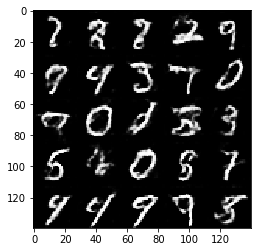

Epoch: 2/2 ... Discriminator Loss is: 1.2206... Generator Loss is: 0.8297
Epoch: 2/2 ... Discriminator Loss is: 1.3550... Generator Loss is: 0.7220
Epoch: 2/2 ... Discriminator Loss is: 1.2200... Generator Loss is: 0.9514
Epoch: 2/2 ... Discriminator Loss is: 1.2069... Generator Loss is: 1.3580
Epoch: 2/2 ... Discriminator Loss is: 1.2270... Generator Loss is: 1.0332
Epoch: 2/2 ... Discriminator Loss is: 1.3325... Generator Loss is: 0.8041
Epoch: 2/2 ... Discriminator Loss is: 1.2828... Generator Loss is: 1.0818
Epoch: 2/2 ... Discriminator Loss is: 1.1568... Generator Loss is: 1.0084
Epoch: 2/2 ... Discriminator Loss is: 1.2081... Generator Loss is: 0.8842
Epoch: 2/2 ... Discriminator Loss is: 1.1847... Generator Loss is: 1.0504


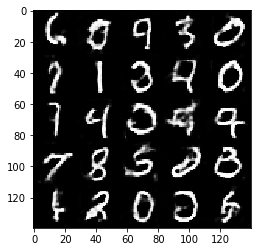

Epoch: 2/2 ... Discriminator Loss is: 1.3111... Generator Loss is: 1.0601
Epoch: 2/2 ... Discriminator Loss is: 1.2733... Generator Loss is: 0.9002
Epoch: 2/2 ... Discriminator Loss is: 1.1837... Generator Loss is: 0.9295
Epoch: 2/2 ... Discriminator Loss is: 1.2388... Generator Loss is: 0.9853
Epoch: 2/2 ... Discriminator Loss is: 1.2153... Generator Loss is: 0.8142
Epoch: 2/2 ... Discriminator Loss is: 1.2326... Generator Loss is: 1.0754
Epoch: 2/2 ... Discriminator Loss is: 1.3232... Generator Loss is: 0.7002
Epoch: 2/2 ... Discriminator Loss is: 1.2441... Generator Loss is: 0.8908
Epoch: 2/2 ... Discriminator Loss is: 1.1804... Generator Loss is: 0.9792
Epoch: 2/2 ... Discriminator Loss is: 1.2126... Generator Loss is: 0.9148


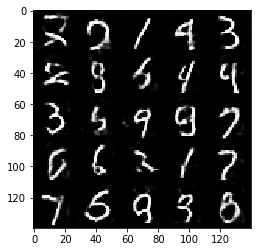

Epoch: 2/2 ... Discriminator Loss is: 1.2771... Generator Loss is: 0.9316
Epoch: 2/2 ... Discriminator Loss is: 1.2229... Generator Loss is: 0.9305
Epoch: 2/2 ... Discriminator Loss is: 1.2210... Generator Loss is: 0.9283
Epoch: 2/2 ... Discriminator Loss is: 1.2441... Generator Loss is: 0.8404
Epoch: 2/2 ... Discriminator Loss is: 0.9468... Generator Loss is: 1.2905
Epoch: 2/2 ... Discriminator Loss is: 1.1279... Generator Loss is: 1.0347
Epoch: 2/2 ... Discriminator Loss is: 1.3572... Generator Loss is: 0.8736
Epoch: 2/2 ... Discriminator Loss is: 1.2256... Generator Loss is: 0.9290
Epoch: 2/2 ... Discriminator Loss is: 1.2797... Generator Loss is: 0.8470
Epoch: 2/2 ... Discriminator Loss is: 1.2199... Generator Loss is: 0.8634


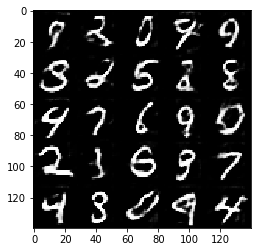

Epoch: 2/2 ... Discriminator Loss is: 1.3170... Generator Loss is: 0.8328


In [12]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch: 1/1 ... Discriminator Loss is: 0.9306... Generator Loss is: 1.1027
Epoch: 1/1 ... Discriminator Loss is: 0.7285... Generator Loss is: 1.2706
Epoch: 1/1 ... Discriminator Loss is: 1.2192... Generator Loss is: 0.8574
Epoch: 1/1 ... Discriminator Loss is: 1.4540... Generator Loss is: 0.9077
Epoch: 1/1 ... Discriminator Loss is: 1.3151... Generator Loss is: 1.1645
Epoch: 1/1 ... Discriminator Loss is: 1.3508... Generator Loss is: 0.9532
Epoch: 1/1 ... Discriminator Loss is: 1.2362... Generator Loss is: 0.9246
Epoch: 1/1 ... Discriminator Loss is: 1.1518... Generator Loss is: 0.9870
Epoch: 1/1 ... Discriminator Loss is: 1.4743... Generator Loss is: 0.6827
Epoch: 1/1 ... Discriminator Loss is: 1.3440... Generator Loss is: 0.8067


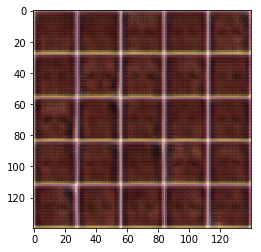

Epoch: 1/1 ... Discriminator Loss is: 1.6022... Generator Loss is: 0.6547
Epoch: 1/1 ... Discriminator Loss is: 1.5709... Generator Loss is: 0.6693
Epoch: 1/1 ... Discriminator Loss is: 1.3895... Generator Loss is: 0.7638
Epoch: 1/1 ... Discriminator Loss is: 1.2973... Generator Loss is: 0.8692
Epoch: 1/1 ... Discriminator Loss is: 1.3003... Generator Loss is: 0.8179
Epoch: 1/1 ... Discriminator Loss is: 1.4332... Generator Loss is: 0.7795
Epoch: 1/1 ... Discriminator Loss is: 1.4916... Generator Loss is: 0.7953
Epoch: 1/1 ... Discriminator Loss is: 1.3587... Generator Loss is: 0.8342
Epoch: 1/1 ... Discriminator Loss is: 1.3640... Generator Loss is: 0.7822
Epoch: 1/1 ... Discriminator Loss is: 1.3485... Generator Loss is: 0.9093


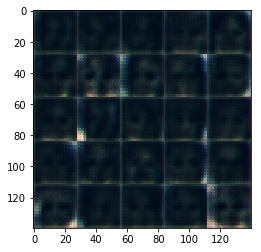

Epoch: 1/1 ... Discriminator Loss is: 1.2742... Generator Loss is: 0.9328
Epoch: 1/1 ... Discriminator Loss is: 1.4255... Generator Loss is: 0.9600
Epoch: 1/1 ... Discriminator Loss is: 1.3638... Generator Loss is: 0.7673
Epoch: 1/1 ... Discriminator Loss is: 1.2497... Generator Loss is: 0.8625
Epoch: 1/1 ... Discriminator Loss is: 1.2219... Generator Loss is: 0.9197
Epoch: 1/1 ... Discriminator Loss is: 1.3909... Generator Loss is: 0.8959
Epoch: 1/1 ... Discriminator Loss is: 1.2719... Generator Loss is: 0.8854
Epoch: 1/1 ... Discriminator Loss is: 1.4236... Generator Loss is: 0.8358
Epoch: 1/1 ... Discriminator Loss is: 1.5114... Generator Loss is: 0.6840
Epoch: 1/1 ... Discriminator Loss is: 1.5527... Generator Loss is: 0.7509


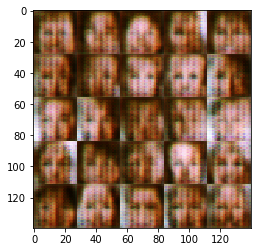

Epoch: 1/1 ... Discriminator Loss is: 1.5476... Generator Loss is: 0.7112
Epoch: 1/1 ... Discriminator Loss is: 1.4121... Generator Loss is: 0.7453
Epoch: 1/1 ... Discriminator Loss is: 1.3821... Generator Loss is: 0.7835
Epoch: 1/1 ... Discriminator Loss is: 1.5444... Generator Loss is: 0.7273
Epoch: 1/1 ... Discriminator Loss is: 1.2834... Generator Loss is: 0.8735
Epoch: 1/1 ... Discriminator Loss is: 1.5386... Generator Loss is: 0.6883
Epoch: 1/1 ... Discriminator Loss is: 1.3156... Generator Loss is: 0.8185
Epoch: 1/1 ... Discriminator Loss is: 1.4295... Generator Loss is: 0.8139
Epoch: 1/1 ... Discriminator Loss is: 1.2472... Generator Loss is: 0.8902
Epoch: 1/1 ... Discriminator Loss is: 1.3198... Generator Loss is: 0.7543


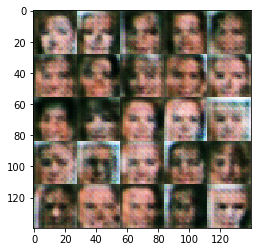

Epoch: 1/1 ... Discriminator Loss is: 1.3939... Generator Loss is: 0.8726
Epoch: 1/1 ... Discriminator Loss is: 1.4221... Generator Loss is: 0.7671
Epoch: 1/1 ... Discriminator Loss is: 1.3449... Generator Loss is: 0.8445
Epoch: 1/1 ... Discriminator Loss is: 1.3770... Generator Loss is: 0.8081
Epoch: 1/1 ... Discriminator Loss is: 1.4082... Generator Loss is: 0.8203
Epoch: 1/1 ... Discriminator Loss is: 1.2596... Generator Loss is: 0.9042
Epoch: 1/1 ... Discriminator Loss is: 1.2910... Generator Loss is: 0.9314
Epoch: 1/1 ... Discriminator Loss is: 1.1152... Generator Loss is: 0.9981
Epoch: 1/1 ... Discriminator Loss is: 1.2466... Generator Loss is: 0.8217
Epoch: 1/1 ... Discriminator Loss is: 1.3443... Generator Loss is: 0.8271


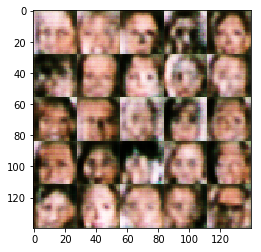

Epoch: 1/1 ... Discriminator Loss is: 1.3426... Generator Loss is: 1.0075
Epoch: 1/1 ... Discriminator Loss is: 1.2771... Generator Loss is: 0.9013
Epoch: 1/1 ... Discriminator Loss is: 1.3106... Generator Loss is: 0.8577
Epoch: 1/1 ... Discriminator Loss is: 1.3032... Generator Loss is: 0.8983
Epoch: 1/1 ... Discriminator Loss is: 1.3315... Generator Loss is: 0.8174
Epoch: 1/1 ... Discriminator Loss is: 1.3291... Generator Loss is: 0.8375
Epoch: 1/1 ... Discriminator Loss is: 1.3550... Generator Loss is: 0.8051
Epoch: 1/1 ... Discriminator Loss is: 1.3478... Generator Loss is: 0.9026
Epoch: 1/1 ... Discriminator Loss is: 1.2988... Generator Loss is: 0.8716
Epoch: 1/1 ... Discriminator Loss is: 1.5244... Generator Loss is: 0.7058


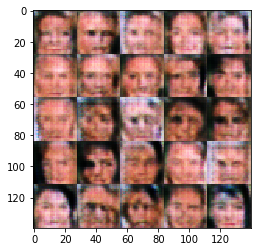

Epoch: 1/1 ... Discriminator Loss is: 1.3175... Generator Loss is: 0.8984
Epoch: 1/1 ... Discriminator Loss is: 1.4428... Generator Loss is: 0.7823
Epoch: 1/1 ... Discriminator Loss is: 1.3746... Generator Loss is: 0.8415
Epoch: 1/1 ... Discriminator Loss is: 1.3873... Generator Loss is: 0.7451
Epoch: 1/1 ... Discriminator Loss is: 1.4220... Generator Loss is: 0.7993
Epoch: 1/1 ... Discriminator Loss is: 1.3195... Generator Loss is: 0.8487
Epoch: 1/1 ... Discriminator Loss is: 1.3840... Generator Loss is: 0.7707
Epoch: 1/1 ... Discriminator Loss is: 1.2901... Generator Loss is: 0.8752
Epoch: 1/1 ... Discriminator Loss is: 1.3482... Generator Loss is: 0.7787
Epoch: 1/1 ... Discriminator Loss is: 1.2852... Generator Loss is: 0.9527


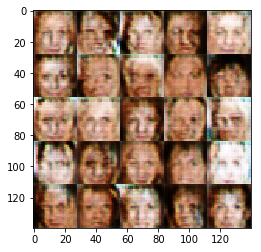

Epoch: 1/1 ... Discriminator Loss is: 1.3828... Generator Loss is: 0.7408
Epoch: 1/1 ... Discriminator Loss is: 1.3227... Generator Loss is: 0.8332
Epoch: 1/1 ... Discriminator Loss is: 1.3419... Generator Loss is: 0.7729
Epoch: 1/1 ... Discriminator Loss is: 1.3887... Generator Loss is: 0.8188
Epoch: 1/1 ... Discriminator Loss is: 1.3823... Generator Loss is: 0.7968
Epoch: 1/1 ... Discriminator Loss is: 1.4498... Generator Loss is: 0.7656
Epoch: 1/1 ... Discriminator Loss is: 1.3558... Generator Loss is: 0.8247
Epoch: 1/1 ... Discriminator Loss is: 1.3888... Generator Loss is: 0.7358
Epoch: 1/1 ... Discriminator Loss is: 1.3488... Generator Loss is: 0.8798
Epoch: 1/1 ... Discriminator Loss is: 1.3593... Generator Loss is: 0.8250


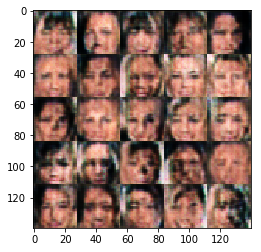

Epoch: 1/1 ... Discriminator Loss is: 1.3471... Generator Loss is: 0.8754
Epoch: 1/1 ... Discriminator Loss is: 1.3688... Generator Loss is: 0.7496
Epoch: 1/1 ... Discriminator Loss is: 1.3821... Generator Loss is: 0.7852
Epoch: 1/1 ... Discriminator Loss is: 1.3218... Generator Loss is: 0.8716
Epoch: 1/1 ... Discriminator Loss is: 1.3461... Generator Loss is: 0.8174
Epoch: 1/1 ... Discriminator Loss is: 1.3868... Generator Loss is: 0.7632
Epoch: 1/1 ... Discriminator Loss is: 1.3156... Generator Loss is: 0.8232
Epoch: 1/1 ... Discriminator Loss is: 1.3775... Generator Loss is: 0.8271
Epoch: 1/1 ... Discriminator Loss is: 1.2954... Generator Loss is: 0.8432
Epoch: 1/1 ... Discriminator Loss is: 1.3695... Generator Loss is: 0.8080


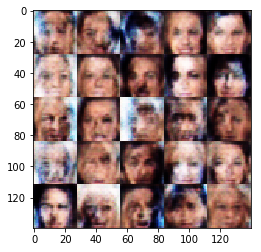

Epoch: 1/1 ... Discriminator Loss is: 1.3425... Generator Loss is: 0.8495
Epoch: 1/1 ... Discriminator Loss is: 1.2783... Generator Loss is: 0.8352
Epoch: 1/1 ... Discriminator Loss is: 1.3599... Generator Loss is: 0.8495
Epoch: 1/1 ... Discriminator Loss is: 1.3073... Generator Loss is: 0.8510
Epoch: 1/1 ... Discriminator Loss is: 1.3693... Generator Loss is: 0.8273
Epoch: 1/1 ... Discriminator Loss is: 1.3753... Generator Loss is: 0.7697
Epoch: 1/1 ... Discriminator Loss is: 1.3201... Generator Loss is: 0.8582
Epoch: 1/1 ... Discriminator Loss is: 1.3891... Generator Loss is: 0.7728
Epoch: 1/1 ... Discriminator Loss is: 1.3348... Generator Loss is: 0.7914
Epoch: 1/1 ... Discriminator Loss is: 1.3164... Generator Loss is: 0.7471


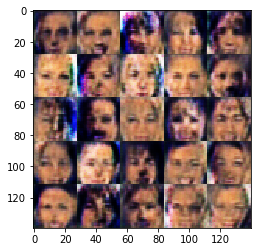

Epoch: 1/1 ... Discriminator Loss is: 1.3440... Generator Loss is: 0.8679
Epoch: 1/1 ... Discriminator Loss is: 1.4039... Generator Loss is: 0.6892
Epoch: 1/1 ... Discriminator Loss is: 1.3793... Generator Loss is: 0.8188
Epoch: 1/1 ... Discriminator Loss is: 1.3173... Generator Loss is: 0.8295
Epoch: 1/1 ... Discriminator Loss is: 1.3409... Generator Loss is: 0.8212
Epoch: 1/1 ... Discriminator Loss is: 1.3385... Generator Loss is: 0.8215
Epoch: 1/1 ... Discriminator Loss is: 1.3495... Generator Loss is: 0.8199
Epoch: 1/1 ... Discriminator Loss is: 1.4141... Generator Loss is: 0.7722
Epoch: 1/1 ... Discriminator Loss is: 1.3076... Generator Loss is: 0.7678
Epoch: 1/1 ... Discriminator Loss is: 1.4307... Generator Loss is: 0.9048


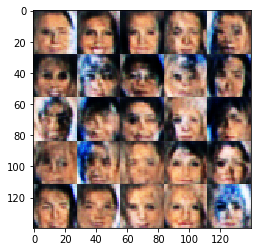

Epoch: 1/1 ... Discriminator Loss is: 1.3279... Generator Loss is: 0.8163
Epoch: 1/1 ... Discriminator Loss is: 1.3819... Generator Loss is: 0.7827
Epoch: 1/1 ... Discriminator Loss is: 1.3031... Generator Loss is: 0.9132
Epoch: 1/1 ... Discriminator Loss is: 1.3852... Generator Loss is: 0.7214
Epoch: 1/1 ... Discriminator Loss is: 1.3948... Generator Loss is: 0.7663
Epoch: 1/1 ... Discriminator Loss is: 1.3499... Generator Loss is: 0.7677
Epoch: 1/1 ... Discriminator Loss is: 1.2974... Generator Loss is: 0.8668
Epoch: 1/1 ... Discriminator Loss is: 1.2786... Generator Loss is: 0.8333
Epoch: 1/1 ... Discriminator Loss is: 1.3502... Generator Loss is: 0.7472
Epoch: 1/1 ... Discriminator Loss is: 1.5135... Generator Loss is: 1.0050


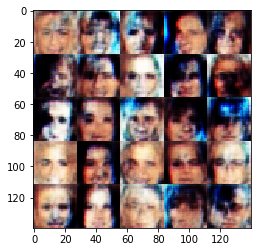

Epoch: 1/1 ... Discriminator Loss is: 1.2799... Generator Loss is: 0.9088
Epoch: 1/1 ... Discriminator Loss is: 1.3353... Generator Loss is: 0.8268
Epoch: 1/1 ... Discriminator Loss is: 1.4084... Generator Loss is: 0.7663
Epoch: 1/1 ... Discriminator Loss is: 1.2981... Generator Loss is: 0.7985
Epoch: 1/1 ... Discriminator Loss is: 1.4387... Generator Loss is: 0.7938
Epoch: 1/1 ... Discriminator Loss is: 1.4060... Generator Loss is: 0.7895
Epoch: 1/1 ... Discriminator Loss is: 1.4737... Generator Loss is: 0.7164
Epoch: 1/1 ... Discriminator Loss is: 1.3239... Generator Loss is: 0.8283
Epoch: 1/1 ... Discriminator Loss is: 1.3543... Generator Loss is: 0.7899
Epoch: 1/1 ... Discriminator Loss is: 1.3129... Generator Loss is: 0.8262


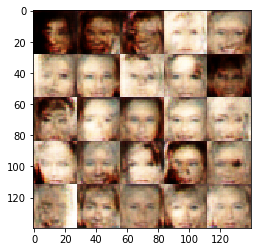

Epoch: 1/1 ... Discriminator Loss is: 1.3475... Generator Loss is: 0.7931
Epoch: 1/1 ... Discriminator Loss is: 1.4467... Generator Loss is: 0.8264
Epoch: 1/1 ... Discriminator Loss is: 1.3531... Generator Loss is: 0.8048
Epoch: 1/1 ... Discriminator Loss is: 1.4307... Generator Loss is: 0.7861
Epoch: 1/1 ... Discriminator Loss is: 1.2507... Generator Loss is: 0.9290
Epoch: 1/1 ... Discriminator Loss is: 1.3859... Generator Loss is: 0.8374
Epoch: 1/1 ... Discriminator Loss is: 1.4119... Generator Loss is: 0.8188
Epoch: 1/1 ... Discriminator Loss is: 1.4046... Generator Loss is: 0.8457
Epoch: 1/1 ... Discriminator Loss is: 1.3829... Generator Loss is: 0.8422
Epoch: 1/1 ... Discriminator Loss is: 1.4420... Generator Loss is: 0.7650


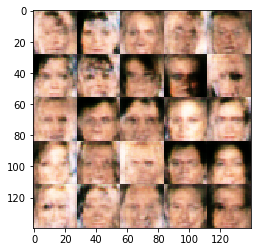

Epoch: 1/1 ... Discriminator Loss is: 1.3799... Generator Loss is: 0.7777
Epoch: 1/1 ... Discriminator Loss is: 1.4401... Generator Loss is: 0.7707
Epoch: 1/1 ... Discriminator Loss is: 1.5634... Generator Loss is: 0.7975
Epoch: 1/1 ... Discriminator Loss is: 1.4639... Generator Loss is: 0.7512
Epoch: 1/1 ... Discriminator Loss is: 1.3002... Generator Loss is: 0.8624
Epoch: 1/1 ... Discriminator Loss is: 1.3583... Generator Loss is: 0.8123
Epoch: 1/1 ... Discriminator Loss is: 1.3519... Generator Loss is: 0.7253
Epoch: 1/1 ... Discriminator Loss is: 1.3267... Generator Loss is: 0.9237
Epoch: 1/1 ... Discriminator Loss is: 1.2944... Generator Loss is: 0.7745
Epoch: 1/1 ... Discriminator Loss is: 1.3094... Generator Loss is: 0.8333


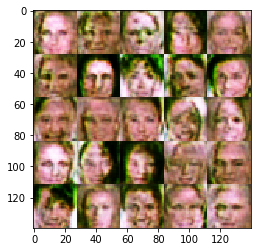

Epoch: 1/1 ... Discriminator Loss is: 1.3043... Generator Loss is: 0.8687
Epoch: 1/1 ... Discriminator Loss is: 1.4767... Generator Loss is: 0.7882
Epoch: 1/1 ... Discriminator Loss is: 1.4117... Generator Loss is: 0.7868
Epoch: 1/1 ... Discriminator Loss is: 1.2880... Generator Loss is: 0.8677
Epoch: 1/1 ... Discriminator Loss is: 1.3025... Generator Loss is: 0.8084
Epoch: 1/1 ... Discriminator Loss is: 1.3510... Generator Loss is: 0.8400
Epoch: 1/1 ... Discriminator Loss is: 1.3425... Generator Loss is: 1.1173
Epoch: 1/1 ... Discriminator Loss is: 1.3293... Generator Loss is: 0.8088


In [13]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.